In [1]:
import glob
import os
import subprocess
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mintpy import view, plot_network
from mintpy.objects import gnss, timeseries, ifgramStack
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, utils as ut
from scipy import signal

from urllib.request import urlretrieve
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
def get_corners(atr):
    """Get corners coordinate."""
    length = int(atr['LENGTH'])
    width = int(atr['WIDTH'])
    W = float(atr['X_FIRST'])
    N = float(atr['Y_FIRST'])
    lon_step = float(atr['X_STEP'])
    lat_step = float(atr['Y_STEP'])
    S = N + lat_step * length
    E = W + lon_step * width

    return S, N, W, E, width, length
insar_velocity1,atr1 = readfile.read(r'C:\Users\bvarugu\Documents\Concord\Asc\velocity_GNSS_msk.h5', datasetName='velocity');
insar_velocity2,atr2 = readfile.read(r'C:\Users\bvarugu\Documents\Lamont_Earthquake\ARIA_products\Asc\velocity_GNSS_integrated_msk.h5', datasetName='velocity');



In [7]:
ratio_x = abs((float(atr1['X_STEP']) - float(atr2['X_STEP'])) / float(atr1['X_STEP']))
ratio_y = abs((float(atr1['Y_STEP']) - float(atr2['Y_STEP'])) / float(atr1['Y_STEP']))
if any(i > 1e-3 for i in [ratio_x, ratio_y]):
    print('file 1: X_STEP - {}, Y_STEP - {}'.format(atr1['X_STEP'], atr1['Y_STEP']))
    print('file 2: X_STEP - {}, Y_STEP - {}'.format(atr2['X_STEP'], atr2['Y_STEP']))
    print('rescale the 2nd matrix into the same spatial resolution as the 1st one ...')
    mat2, atr2 = rescale_data(mat2, meta=atr2, ref_meta=atr1)

# input spatial extents
print('grab corners of input matrices')
S1, N1, W1, E1, width1, length1 = get_corners(atr1)
S2, N2, W2, E2, width2, length2 = get_corners(atr2)
print(S1, N1, W1, E1, width1, length1);
print(S2, N2, W2, E2, width2, length2);
# output spatial extent
print('calculate corners of output matrix')
W, E = min(W1, W2), max(E1, E2)
S, N = min(S1, S2), max(N1, N2)
print(S,N,W,E)
lon_step = float(atr1['X_STEP'])
lat_step = float(atr1['Y_STEP'])
width  = int(np.ceil((E - W) / lon_step))
length = int(np.ceil((S - N) / lat_step))
print('Combined matrix shape is:',width,length)

grab corners of input matrices
35.580819101 37.403318372 -121.670784665 -118.501619266 3803 2187
34.419152899000004 36.24165217 -121.390784777 -118.23328604 3789 2187
calculate corners of output matrix
34.419152899000004 37.403318372 -121.670784665 -118.23328604
Combined matrix shape is: 4126 3581


In [9]:
print('estimate difference in the overlapping area')
lon_seq = np.linspace(W, W + width  * lon_step, width, endpoint=False);
lat_seq = np.linspace(N, N + length * lat_step, length, endpoint=False);
lons,lats= np.meshgrid(lon_seq,lat_seq);
x1, y1 = np.argmin(np.square(lon_seq - W1)), np.argmin(np.square(lat_seq - N1))
x2, y2 = np.argmin(np.square(lon_seq - W2)), np.argmin(np.square(lat_seq - N2))
print(x1,y1,x1+width1,y1+length1)
print(x2,y2,x2+width2,y2+length2)
# estimate offset of the overlapping area
mat11 = np.zeros([length, width]) * np.nan;
mat22 = np.zeros([length, width]) * np.nan;
mat11[y1:y1+length1, x1:x1+width1] = insar_velocity1
mat22[y2:y2+length2, x2:x2+width2] = insar_velocity2
mat_diff = mat22 - mat11  ###the finite or non-nan values in this matrix correspond to the overlap area

offset = np.nansum(mat_diff) / np.sum(np.isfinite(mat_diff))
print(f'Average offset between the two frames is:{np.round(offset,4)}m');
flag = np.isfinite(mat_diff);
overlap_length = len(mat_diff[flag])
print(f'No. of pixels in the overlap area:{overlap_length}')

estimate difference in the overlapping area
0 0 3803 2187
336 1394 4125 3581
Average offset between the two frames is:0.0008m
No. of pixels in the overlap area:1339451


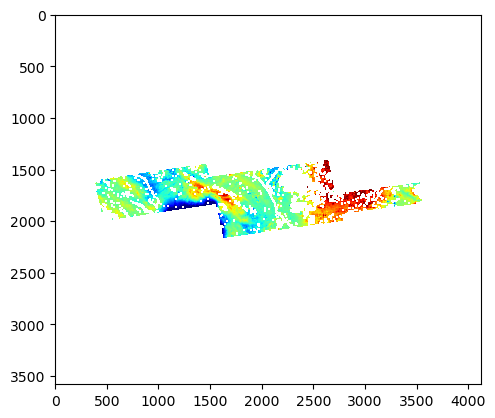

In [13]:
plt.imshow(mat_diff,cmap='jet',vmin=-0.01,vmax=0.01)